# Analyse des données liées au COVID-19 en France
Données issues de l'Agance nationale de santé publique (Santé publique France).

## Importation des modules

In [42]:
import requests

In [43]:
from datetime import datetime

In [44]:
import pandas as pd 

In [45]:
import numpy as np 

In [46]:
import matplotlib.pyplot as plt 
%matplotlib inline

## Fonctions

In [47]:
# Récupération des fichiers .csv
def get_csv(url, file_name):
    req = requests.get(url) # Envoi de la requête

    if req.status_code == 200:
        print("LINK OK")
    else:
        print(req.status_code)

    url_content = req.content # Binary content
    csv_file = open(f'{file_name}.csv', 'wb')

    csv_file.write(url_content)
    csv_file.close()

    now = datetime.now()
    when = now.strftime("%d/%m/%Y à %H:%M:%S")
    print("Dernière mise à jour du CSV le", when)

    return pd.read_csv(f'{file_name}.csv', sep=";")

In [64]:
# Fonction calculant les variations de valeurs dans une série sous la forme d'un plot.bar à deux barres
# series = Prend un pandas.core.series.Series en paramètres
# mode="day" : Variation entre hier et aujourd'hui
# mode="week" : Variation entre les 7 derniers jours et les 7 précédents
# title="" : Titre du graph
# grid = False/True : Afficher ou non la grille
# absolute=True : Affiche la valeur absolue sur le graph
# absolute=False : Affiche la valeur avec l'opérateur +/- en préfixe sur le graph
# inv_color=False : La barre représantant la valeur la plus récente apparait en rouge si elle est supérieure
# inv_color=True : La barre représantant la valeur la plus récente apparait en vert si elle est supérieure  

def vario(series, mode="day", title="", grid=False, absolute=True, inv_color = False):
    if mode == "day":
        last = series[len(series)-1]
        b_last = series[len(series)-2]
        diff = last - b_last
        perc = round(((last/b_last)*100)-100, 2)

    if mode == "week":
        last_week = []
        b_last_week = []
        i = len(series)-1

        while i > (len(series)-1) - 7:
            last_week.append(series[i])
            i-=1

        while i > (len(series)-1) - 14:
            b_last_week.append(series[i])
            i-=1
        
        last = sum(last_week)
        b_last = sum(b_last_week)
        diff = last - b_last
        perc = round(((last/b_last)*100)-100, 2)

    color = ["lime", "coral"]
    if inv_color:
        color.reverse()

    if last > b_last: # Variation +
        if mode == "day":
            print(f"Variation journalière = +{diff} [{perc}%] (Auj. : {last}, hier : {b_last})")
        else :
            print(f"Variation hébdomadaire = +{diff} [{perc}%] (Cette sem. : {last}, Sem. der. : {b_last})")
        color = color

    elif last == b_last: # No variation
        if mode == "day":
            print(f"Variation journalière = +{diff} [{perc}%] (Auj. : {last}, hier : {b_last})")
        else :
            print(f"Variation hébdomadaire = +{diff} [{perc}%] (Cette sem. : {last}, Sem. der. : {b_last})")
        color = ["b", "b"]

    else : # Variation -
        if mode == "day":
            print(f"Variation journalière = {diff} [{perc}%] (Auj. : {last}, hier : {b_last})")
        else :
            print(f"Variation hébdomadaire = {diff} [{perc}%] (Cette sem. : {last}, Sem. der. : {b_last})")
        color.reverse()
    
    now = datetime.now()
    when = now.strftime("Le %d/%m/%Y")

    if mode == "day":
        df = pd.DataFrame({'jour':['Hier.', 'Auj.'], 'y':[b_last, last]})
        ax = df.plot.bar(x='jour', y='y', rot=0, color=color, legend=False, title = f"{title}\n ({when})")
    else:
        df = pd.DataFrame({'semaine':['Sem. der.', 'Cette sem.'], 'y':[b_last, last]})
        ax = df.plot.bar(x='semaine', y='y', rot=0, color=color, legend=False, title = f"{title}\n ({when})")

    x_offset = -0.1

    for p in ax.patches:
        b = p.get_bbox()
        if absolute:
            val = "{:.0f}".format(b.y1)
        else :
            val = "{:+.0f}".format(b.y1)     
        ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 - (b.y1/10)))
    
    return ax

## Récupération des fichiers .csv

### Données hospitalières cumulées
Données cumulées depuis le début des mesures en mars 2020.
3 nouvelles entrées par jour et par département

In [49]:
# Récupération du fichier .csv à partir d'une URL stable
url = "https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7"
cov = get_csv(url, "cov")

LINK OK
Dernière mise à jour du CSV le 25/11/2020 à 11:42:02


### Nouvelles données hospitalières
Variations journalières des données hospitalières

In [50]:
# Récupération du fichier .csv à partir d'une URL stable
url = "https://www.data.gouv.fr/fr/datasets/r/6fadff46-9efd-4c53-942a-54aca783c30c"
covn = get_csv(url, "covn")

LINK OK
Dernière mise à jour du CSV le 25/11/2020 à 11:42:02


### Données par classes d'âge
Données hospitalières en fonction de la classe d'âge des patients

In [51]:
url = "https://www.data.gouv.fr/fr/datasets/r/08c18e08-6780-452d-9b8c-ae244ad529b3"
cova = get_csv(url, "cova")

LINK OK
Dernière mise à jour du CSV le 25/11/2020 à 11:42:03


## Exploration des données

### Explorations des données hospitalières cumulées
cov.csv

In [52]:
# Dimensions du dataset (lignes, colonnes)
cov.shape

(76356, 7)

In [53]:
# Affichage des dernières lignes
cov.tail()

,dep,sexe,jour,hosp,rea,rad,dc
76351,974,1,2020-11-24,45,7,299,21
76352,974,2,2020-11-24,38,7,301,24
76353,976,0,2020-11-24,11,4,506,35
76354,976,1,2020-11-24,7,2,243,21
76355,976,2,2020-11-24,4,2,257,14


In [54]:
# Description générale du dataset
cov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76356 entries, 0 to 76355
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   dep     76356 non-null  object
 1   sexe    76356 non-null  int64 
 2   jour    76356 non-null  object
 3   hosp    76356 non-null  int64 
 4   rea     76356 non-null  int64 
 5   rad     76356 non-null  int64 
 6   dc      76356 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 4.1+ MB


Informations sur les colonnes :

dep = Département (type 'str' et non 'int' car dep. Corse = 2A et 2B)

sexe = 0 : h/f | 1 : h | 2 : f

jour = Date de notification

hosp = Nombre d'hospitalisations

rea = Nombre de patients en réanimation

rad = Nombre de personnes retournées à domicile

dc = Nombre de décès en milieu hospitalier


### Exploration des nouvelles données hospitalières
covn.csv

In [55]:
covn.shape

(25351, 6)

In [56]:
covn.tail()

,dep,jour,incid_hosp,incid_rea,incid_dc,incid_rad
25346,976,2020-11-20,1,0,0,0
25347,976,2020-11-21,1,0,0,2
25348,976,2020-11-22,0,0,0,0
25349,976,2020-11-23,1,0,1,0
25350,976,2020-11-24,1,0,0,1


In [57]:
covn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25351 entries, 0 to 25350
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   dep         25351 non-null  object
 1   jour        25351 non-null  object
 2   incid_hosp  25351 non-null  int64 
 3   incid_rea   25351 non-null  int64 
 4   incid_dc    25351 non-null  int64 
 5   incid_rad   25351 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 1.2+ MB


Informations sur les colonnes :

dep = département (type 'str' et non 'int' car dep. Corse = 2A et 2B)

jour = Date de notification

incid_hosp = Nombre quotidien de personnes nouvellement hospitalisées

incid_rea = Nombre quotidien de nouvelles admissions en réanimation

incid_dc = Nombre quotidien de personnes nouvellement décédées

incid_rad = Nombre quotidien de nouveaux retours à domicile

### Exploration des données hospitalières par classes d'âge
cova.csv

In [58]:
cova.shape

(49896, 7)

In [59]:
cova.tail()

,reg,cl_age90,jour,hosp,rea,rad,dc
49891,94,59,2020-11-24,3,1,74,5
49892,94,69,2020-11-24,11,5,78,10
49893,94,79,2020-11-24,8,0,103,27
49894,94,89,2020-11-24,14,0,80,47
49895,94,90,2020-11-24,6,0,27,18


In [60]:
cova.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49896 entries, 0 to 49895
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   reg       49896 non-null  int64 
 1   cl_age90  49896 non-null  int64 
 2   jour      49896 non-null  object
 3   hosp      49896 non-null  int64 
 4   rea       49896 non-null  int64 
 5   rad       49896 non-null  int64 
 6   dc        49896 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 2.7+ MB


In [61]:
# Listage des valeurs uniques de la colonne cl_age90
cova['cl_age90'].unique()

array([ 0,  9, 19, 29, 39, 49, 59, 69, 79, 89, 90], dtype=int64)

Informations sur les colonnes :

reg = Région départementale

cl_age90 :

0 = Toutes classes d'âge confondues

9 = 0-9 ans

19 = 10-19 ans

29 = 20-29 ans

39 = 30-39 ans

49 = 40-49 ans

59 = 50-59 ans

69 = 60-69 ans

79 = 70-79 ans

89 = 80-89 ans

90 = 90+ ans

jour = Date de notification

hosp = Nombre de personnes actuellement hospitalisées

rea = Nombre de personnes actuellement en réanimation ou soins intensifs

rad = Nombre cumulé de personnes retournées à domicile

dc = Nombre cumulé de personnes décédées

## Visualisation

### Tout le territoire

#### Réanimations

In [62]:
cov_0 = cov.loc[cov['sexe'] == 0]
cov_rea = cov_0.groupby("jour").rea.sum()

Variation journalière = -161 [-3.63%] (Auj. : 4277, hier : 4438)


<AxesSubplot:title={'center':'Nombres de personnes en réanimation\n ou en soins intensifs (48h)\n (Le 25/11/2020)'}, xlabel='jour'>

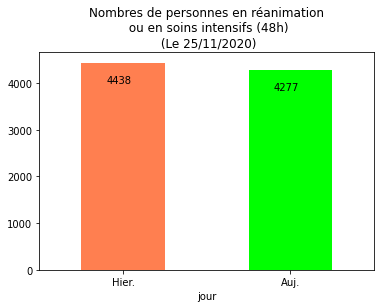

In [67]:
# Variations jour
vario(cov_rea, title="Nombres de personnes en réanimation\n ou en soins intensifs (48h)")

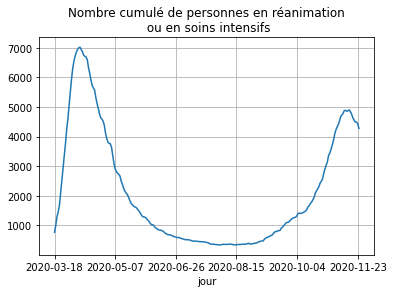

In [23]:
# Réanimations total
rea_graph = cov_rea.plot(grid=True, title="Nombre cumulé de personnes en réanimation\n ou en soins intensifs")

<AxesSubplot:title={'center':'Nombre quotidien de nouvelles admissions en réanimation'}, xlabel='jour'>

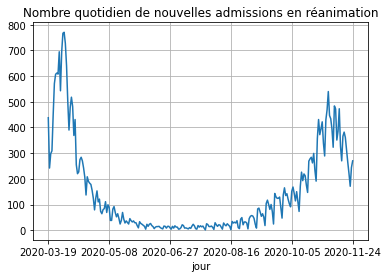

In [24]:
# Nouvelles réanimations
covn_rea = covn.groupby("jour").incid_rea.sum()
covn_rea.plot(title="Nombre quotidien de nouvelles admissions en réanimation", grid=True)

Variation journalière = +26 [10.66%] (Auj. : 270, hier : 244)


<AxesSubplot:title={'center':'Nouvelles admissions en réanimation (48h)\n (Le 25/11/2020)'}, xlabel='jour'>

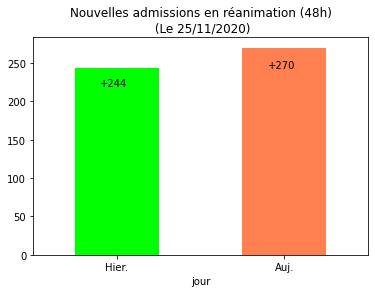

In [68]:
# Variation nouvelles admissions en réanimation
vario(covn_rea, title="Nouvelles admissions en réanimation (48h)", absolute=False)

Variation hébdomadaire = -714 [-27.95%] (Cette sem. : 1841, Sem. der. : 2555)


<AxesSubplot:title={'center':'Nouvelles admissions en réanimation (14jr)\n (Le 25/11/2020)'}, xlabel='semaine'>

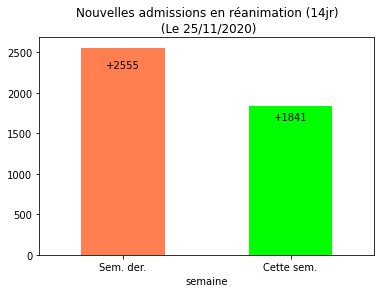

In [71]:
vario(covn_rea, title="Nouvelles admissions en réanimation (14jr)", mode="week", absolute=False)

#### Hospitalisations

<AxesSubplot:title={'center':'Nombre cumulé de personnes hospitalisées'}, xlabel='jour'>

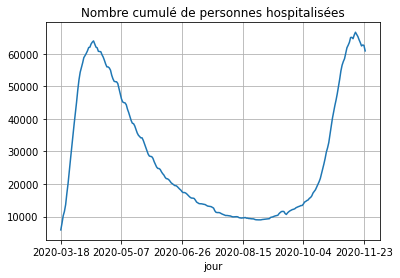

In [26]:
# Hospitalisations
cov_hosp = cov.groupby("jour").hosp.sum()
cov_hosp.plot(grid=True, title="Nombre cumulé de personnes hospitalisées")

<AxesSubplot:title={'center':'Nouvelles hospitalisations'}, xlabel='jour'>

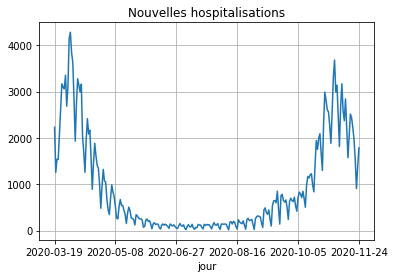

In [27]:
covn_hosp = covn.groupby("jour").incid_hosp.sum()
covn_hosp.plot(title="Nouvelles hospitalisations", grid=True)

Variation journalière = +406 [29.42%] (Auj. : 1786, hier : 1380)


<AxesSubplot:title={'center':'Nouvelles hospitalisations (48h)\n (Le 25/11/2020)'}, xlabel='jour'>

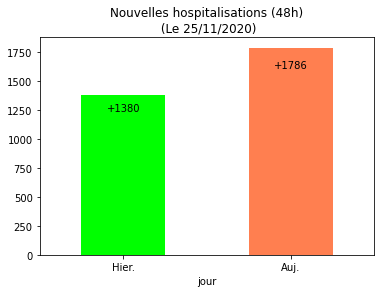

In [69]:
vario(covn_hosp, title="Nouvelles hospitalisations (48h)", absolute=False)

Variation hébdomadaire = -3943 [-24.41%] (Cette sem. : 12211, Sem. der. : 16154)


<AxesSubplot:title={'center':'Nouvelles hospitalisations (48h)\n (Le 25/11/2020)'}, xlabel='semaine'>

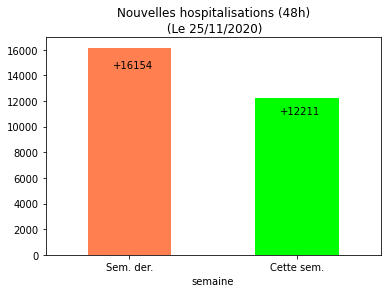

In [72]:
vario(covn_hosp, title="Nouvelles hospitalisations (48h)", mode="week", absolute=False)

#### Décès

<AxesSubplot:title={'center':'Nombre de décès cumulé en milieu hospitalier'}, xlabel='jour'>

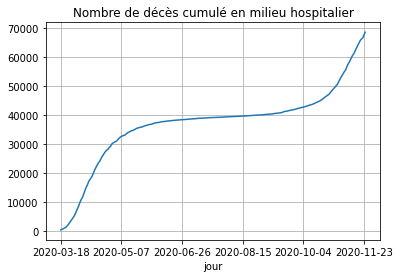

In [29]:
cov_dc = cov.groupby("jour").dc.sum()
cov_dc.plot(grid=True, title="Nombre de décès cumulé en milieu hospitalier")

<AxesSubplot:title={'center':'Nouveaux décès'}, xlabel='jour'>

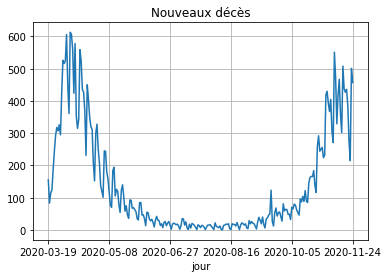

In [30]:
covn_dc = covn.groupby("jour").incid_dc.sum()
covn_dc.plot(title="Nouveaux décès", grid=True)

Variation journalière = -44 [-8.78%] (Auj. : 457, hier : 501)


<AxesSubplot:title={'center':'Nouveaux décès (48h)\n (Le 25/11/2020)'}, xlabel='jour'>

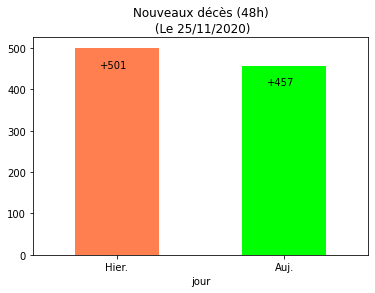

In [38]:
vario(covn_dc, title="Nouveaux décès (48h)", absolute=False)

Variation hébdomadaire = -122 [-4.33%] (Cette sem. : 2698, Sem. der. : 2820)


<AxesSubplot:title={'center':'Nouveaux décès (14 jr)\n (Le 25/11/2020)'}, xlabel='semaine'>

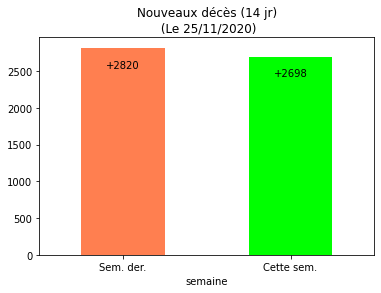

In [37]:
vario(covn_dc, mode="week", title="Nouveaux décès (14 jr)", absolute=False)

#### Retours à domicile

<AxesSubplot:title={'center':'Nouveaux retours à domicile'}, xlabel='jour'>

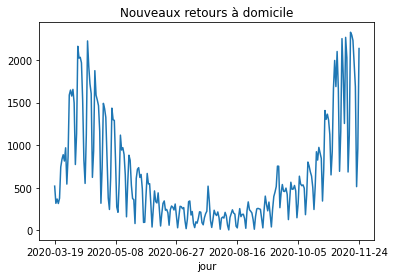

In [33]:
covn_rad = covn.groupby("jour").incid_rad.sum()
covn_rad.plot(title="Nouveaux retours à domicile")

Variation journalière = +1175 [122.4%] (Auj. : 2135, hier : 960)


<AxesSubplot:title={'center':'Retours à domicile (48h)\n (Le 25/11/2020)'}, xlabel='jour'>

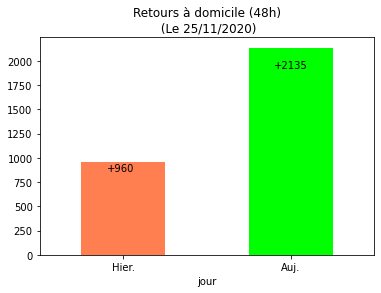

In [66]:
vario(covn_rad, title="Retours à domicile (48h)", absolute=False, inv_color=True)

Variation hébdomadaire = +288 [2.5%] (Cette sem. : 11789, Sem. der. : 11501)


<AxesSubplot:title={'center':'Retours à domicile (48h)\n (Le 25/11/2020)'}, xlabel='semaine'>

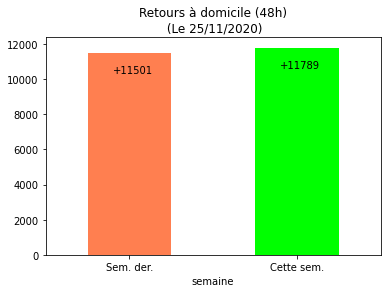

In [73]:
vario(covn_rad, title="Retours à domicile (48h)", mode="week", absolute=False, inv_color=True)

#### Classes d'âge

[0.4, 0.3, 1.0, 2.7, 6.7, 17.6, 31.4, 30.8, 7.6, 0.7]


<AxesSubplot:title={'center':"Total des entrées en réanimation par tranche d'âge"}, ylabel='rea'>

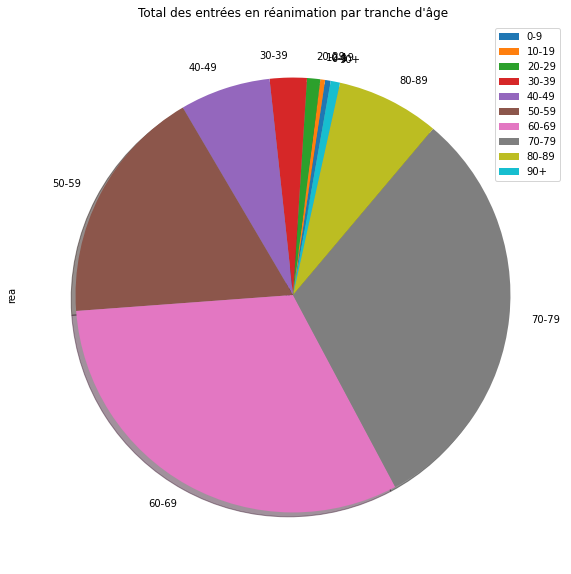

In [34]:
cova_rea = cova.groupby("cl_age90").rea.sum()
total_rea = cova_rea[0]
cova_rea = cova_rea.drop(0)

perc = []
for val in cova_rea:
    res = (val/total_rea)*100
    res = round(res, 1)
    perc.append(res)
print(perc)

labels = ["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-79","80-89", "90+"]
cova_rea.plot.pie(title="Total des entrées en réanimation par tranche d'âge", figsize=(10,10), shadow=True, startangle=80, legend=True, labels=labels)

In [35]:
cova_rea

cl_age90
9       2192
19      1850
29      5173
39     14474
49     35491
59     93211
69    166451
79    163516
89     40409
90      3646
Name: rea, dtype: int64

#### Données croisées

In [36]:
cov_rea.to_frame()
hosp_cov.to_frame()
rea_graph = cov_rea.plot(x="jour", y="rea")
hosp_graph = hosp_cov.plot(x="jour", y="hosp", title="Hospitalisation / réanimation\n pour COVID-19 en France")
hosp_graph.legend(["Réanimations", "Hospitalisation"])
print(type(hosp_graph))

NameError: name 'hosp_cov' is not defined

### Par département

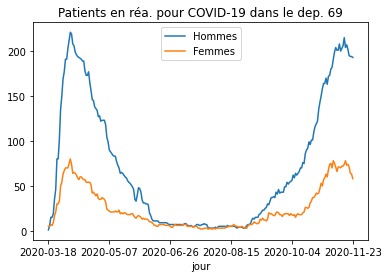

In [284]:
dep = "69" # Changer le département
cov_dep = cov.loc[cov['dep'] == dep]

cov_dep_0 = cov_dep.loc[cov_dep['sexe'] == 0] # Just H/F
cov_dep_1 = cov_dep.loc[cov_dep['sexe'] == 1] # Just H
cov_dep_2 = cov_dep.loc[cov_dep['sexe'] == 2] # Just F

title = f"Patients en réa. pour COVID-19 dans le dep. {dep}"

rea_1 = cov_dep_1.plot(x="jour", y="rea")
rea_2 = cov_dep_2.plot(x="jour", y="rea", ax=rea_1, grid=False, title = title)
rea_2.legend(["Hommes", "Femmes"])

<AxesSubplot:title={'center':'Nouvelles entrées en réanimation\n dans le département 69'}, xlabel='jour'>

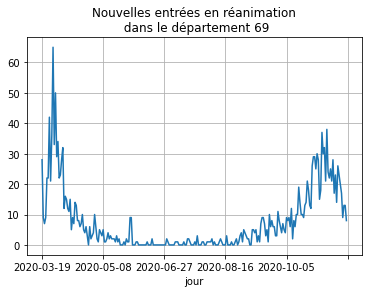

In [285]:
dep = "69"
covnDep = covn.loc[covn['dep'] == dep]
covnDep_rea = covnDep.groupby("jour").incid_rea.sum()
covnDep_rea.plot(title=f"Nouvelles entrées en réanimation\n dans le département {dep}", grid=True)

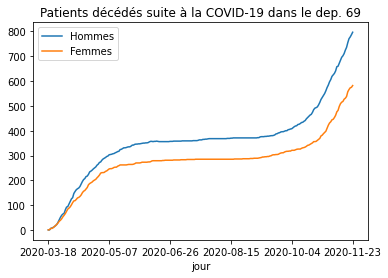

In [286]:
dep = "69"

cov_dep = cov.loc[cov['dep'] == dep]

cov_dep_1 = cov_dep.loc[cov_dep['sexe'] == 1] # Just H
cov_dep_2 = cov_dep.loc[cov_dep['sexe'] == 2] # Just F

title = f"Patients décédés suite à la COVID-19 dans le dep. {dep}"

dc_1 = cov_dep_1.plot(x="jour", y="dc")
dc_2 = cov_dep_2.plot(x="jour", y="dc", ax=dc_1, grid=False, title = title)
dc_2.legend(["Hommes", "Femmes"])